# Loss Landscape Visualization in the Time-Series Domain.
### Interactive Notebook for "Revisiting Linear Mode Connectivity for Generalized Time-Series Forecasting" (Work In Progress)
- Learning generalized representations for Time-series Forecasting is challenging owing to its unique nature in data. A common idea is that time-series data is distinctly different from other data modalities (e.g., Image, Text), namely, an absence of invariant features that are shared across distribution shifts \cite{meiseles2020source, zhang2022self}. In this paper, we investigate the notion of time-series exceptionalism through the lens of Linear Mode Connectivity.
- We adopt a Loss Landscape Visualization method was introduced in Li et al. (2018) (https://arxiv.org/abs/1712.09913v3), which leverages a filter normalization method for effective visualization of an extremely high dimensional space.

#### !!!!Warning: Requires the notebook to be located in the 'Time-Series-Library' folder (https://github.com/thuml/Time-Series-Library)!!!!
#### Required Libraries: loss-landscape
- Please install with: pip install loss-landscapes (https://github.com/marcellodebernardi/loss-landscapes)

In [ ]:
#! pip install loss-landscapes

## 1. Train Model
- We begin with training a time-series forecasting model at ETT-1

In [2]:
import sys,os
sys.path.append(os.path.dirname(os.path.abspath('')))
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from copy import deepcopy

import argparse
import torch
import random
import numpy as np

In [3]:
parser1 = argparse.ArgumentParser(description='ETT1')

# basic config
parser1.add_argument('--task_name', type=str, required=False, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser1.add_argument('--is_training', type=int, required=False, default=1, help='status')
parser1.add_argument('--model_id', type=str, required=False, default='ETTh1_96_96', help='model id')
parser1.add_argument('--model', type=str, required=False, default='DLinear',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

# data loader
parser1.add_argument('--data', type=str, required=False, default='ETTh1', help='dataset type')
parser1.add_argument('--root_path', type=str, default="/workspace/dkcho/Time-Series-Library/dataset/ETT-small/", help='root path of the data file') #'data/'
parser1.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser1.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser1.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser1.add_argument('--freq', type=str, default='h',
                     help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
#parser.add_argument('--freq', type=str, default='m',
#                    help='Change to embedding category features')
parser1.add_argument('--checkpoints', type=str, default='./checkpoints_ours/', help='location of model checkpoints')

# forecasting task
parser1.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser1.add_argument('--label_len', type=int, default=48, help='start token length')
parser1.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser1.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')

# model define
parser1.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser1.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser1.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser1.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser1.add_argument('--c_out', type=int, default=7, help='output size')
parser1.add_argument('--d_model', type=int, default=16, help='dimension of model')
parser1.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser1.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser1.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser1.add_argument('--d_ff', type=int, default=32, help='dimension of fcn')
parser1.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser1.add_argument('--factor', type=int, default=1, help='attn factor')
parser1.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser1.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser1.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser1.add_argument('--activation', type=str, default='gelu', help='activation')
parser1.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser1.add_argument('--inverse', action='store_true', help='inverse output data', default=False)
#parser1.add_argument('--d_latent', type=int, default=256, help='latent dimension size of LGPred')
#parser1.add_argument('--d_feat', type=int, default=256, help='feature size of LGPred')
#parser1.add_argument('--kernel_num', type=int, default=3, help='kernel size of LGPred')
#parser1.add_argument('--d_rep', type=int, default=512, help='dimension of representation in LGPred')

# optimization
parser1.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser1.add_argument('--itr', type=int, default=1, help='experiments times')
parser1.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser1.add_argument('--batch_size', type=int, default=10, help='batch size of train input data')
#parser1.add_argument('--test_batch_size', type=int, default=0, help='batch size of test input data')
parser1.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser1.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser1.add_argument('--des', type=str, default='Exp', help='exp description')
parser1.add_argument('--loss', type=str, default='MSE', help='loss function')
parser1.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser1.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
parser1.add_argument('--pct_start',type=float, default=0.3, help='pct start for one cycle lr schedule')

# GPU
parser1.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser1.add_argument('--gpu', type=int, default=0, help='gpu')
parser1.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser1.add_argument('--devices', type=str, default='0', help='device ids of multile gpus')

# de-stationary projector params
parser1.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
parser1.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')


# Added by Jun
parser1.add_argument('--verbose', action='store_true', help='control print option', default=False)

# news feature configs
parser1.add_argument('--news_dim', type=int, default=5120, help='news feature size')
parser1.add_argument('--news_feature_dim', type=int, default=2, help='integrated news feature size')
parser1.add_argument('--n_heads_news', type=int, default=1, help='num of heads for news features')
parser1.add_argument('--news_path', type=str, default='oracle_news_features_backtest_lithium_LLaMA2_13B_chat.pkl', help='news features file')
parser1.add_argument('--language_model', type=str, default='Exaone_lucida', help='Language model name')

#Patch TST
parser1.add_argument('--patch_len', type=int, default=16, help='patch len for patchtst')
parser1.add_argument('--stride', type=int, default=8, help='stride for patchtst')

args1 = parser1.parse_args(args=[])

In [4]:
args1.use_gpu = True if torch.cuda.is_available() and args1.use_gpu else False

if args1.use_gpu and args1.use_multi_gpu:
    args1.devices = args1.devices.replace(' ', '')
    device_ids = args1.devices.split(',')
    args1.device_ids = [int(id_) for id_ in device_ids]
    args1.gpu = args1.device_ids[0]

if args1.task_name == 'long_term_forecast_LGES':
    Exp1 = Exp_Long_Term_Forecast_LGES
elif args1.task_name == 'long_term_forecast_LGES_news':
    Exp1 = Exp_Long_Term_Forecast_LGES_News
else:
    Exp1 = Exp_Long_Term_Forecast

In [5]:
seeds= [50,100,150,200,250,300,350,400,450,500]
accs = [] 
args1.pred_len = 150  
for ii in range(args1.itr):
    fix_seed = seeds[ii]
    random.seed(fix_seed)
    torch.manual_seed(fix_seed)
    np.random.seed(fix_seed)

    setting1 = '{}_{}_{}_{}_pl{}_ep{}_lr{}_nd{}_{}'.format(
        args1.model,
        args1.data,
        args1.model_id,
        args1.task_name,
        args1.pred_len, 
        args1.train_epochs,
        args1.learning_rate,
        args1.news_feature_dim,
        ii)
    exp1 = Exp1(args1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting1))
    exp1.train(setting1)

    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting1))
    #_,_,_, acc = exp.test(setting)
    mae, mse, rmse, mape, mspe= exp1.test(setting1)
    results= [mae, mse, rmse, mape, mspe]
    accs.append(results)
    torch.cuda.empty_cache()
print(accs)
acc_dict = {}

Use GPU: cuda:0
>>>>>>>start training : DLinear_ETTh1_ETTh1_96_96_long_term_forecast_pl150_ep10_lr0.0001_nd2_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8395
val 2731
test 2731
	iters: 100, epoch: 1 | loss: 0.4657069
	speed: 0.0325s/iter; left time: 269.6656s
	iters: 200, epoch: 1 | loss: 0.5066276
	speed: 0.0222s/iter; left time: 182.2488s
	iters: 300, epoch: 1 | loss: 0.3935400
	speed: 0.0223s/iter; left time: 180.2185s
	iters: 400, epoch: 1 | loss: 0.3801882
	speed: 0.0223s/iter; left time: 177.8777s
	iters: 500, epoch: 1 | loss: 0.4025122
	speed: 0.0222s/iter; left time: 174.9621s
	iters: 600, epoch: 1 | loss: 0.4656800
	speed: 0.0221s/iter; left time: 172.2406s
	iters: 700, epoch: 1 | loss: 0.5104854
	speed: 0.0224s/iter; left time: 172.0605s
	iters: 800, epoch: 1 | loss: 0.2847226
	speed: 0.0222s/iter; left time: 168.3767s
Epoch: 1 cost time: 19.20557951927185
Epoch: 1, Steps: 839 | Train Loss: 0.4287151 Vali Loss: 0.8273996 Test Loss: 0.4296695
Validation loss decreased (inf --> 0.827400)

### 1-1. Get Data for Loss Landscape Visualization!

In [6]:
data, data_loader= exp1._get_data(flag='train')

train 8395


## 2. Loss Landscape Visualization

In [7]:
%matplotlib inline

import loss_landscapes
import loss_landscapes.metrics
import abc
import itertools
import torch.nn

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import copy
import typing
import torch
import torch.autograd
import torch.nn
import numpy as np

#from loss_landscapes.model_interface.model_wrapper import ModelWrapper, wrap_model
from loss_landscapes.model_interface.model_parameters import rand_u_like, orthogonal_to
from loss_landscapes.metrics.metric import Metric
from loss_landscapes.model_interface.model_parameters import ModelParameters

matplotlib.rcParams['figure.figsize'] = [12, 12]

In [8]:
""" Class used to define interface to complex models """

class ModelWrapper(abc.ABC):
    def __init__(self, modules: list):
        self.modules = modules

    def get_modules(self) -> list:
        return self.modules

    def get_module_parameters(self) -> ModelParameters:
        return ModelParameters([p for module in self.modules for p in module.parameters()])

    def train(self, mode=True) -> 'ModelWrapper':
        for module in self.modules:
            module.train(mode)
        return self

    def eval(self) -> 'ModelWrapper':
        return self.train(False)

    def requires_grad_(self, requires_grad=True) -> 'ModelWrapper':
        for module in self.modules:
            for p in module.parameters():
                p.requires_grad = requires_grad
        return self

    def zero_grad(self) -> 'ModelWrapper':
        for module in self.modules:
            for p in module.parameters():
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad.zero_()
        return self

    def parameters(self):
        return itertools.chain([module.parameters() for module in self.modules])

    def named_parameters(self):
        return itertools.chain([module.named_parameters() for module in self.modules])

    @abc.abstractmethod
    def forward(self, x):
        pass


class SimpleModelWrapper(ModelWrapper):
    def __init__(self, model: torch.nn.Module):
        super().__init__([model])

    def forward(self, batch_x, batch_x_mark, dec_inp, batch_y_mark):
        return self.modules[0](batch_x, batch_x_mark, dec_inp, batch_y_mark)


class GeneralModelWrapper(ModelWrapper):
    def __init__(self, model, modules: list, forward_fn):
        super().__init__(modules)
        self.model = model
        self.forward_fn = forward_fn

    def forward(self, x):
        return self.forward_fn(self.model, x)


def wrap_model(model):
    if isinstance(model, ModelWrapper):
        return model.requires_grad_(False)
    elif isinstance(model, torch.nn.Module):
        return SimpleModelWrapper(model).requires_grad_(False)
    else:
        raise ValueError('Only models of type torch.nn.modules.module.Module can be passed without a wrapper.')

In [9]:
# stores the initial point in parameter space
model_final = copy.deepcopy(exp1.model)

In [10]:
#x= [batch_x, batch_y, batch_x_mark, batch_y_mark]
x= iter(data_loader).__next__()

In [11]:
#Reference: https://github.com/thuml/Time-Series-Library/blob/main/exp/exp_long_term_forecasting.py
#Reference: https://github.com/marcellodebernardi/loss-landscapes/blob/master/examples/core-features.ipynb
#NOTE: This code was written for DLinear ONLY. Other models may require changes in code. Please check our reference codes above.

class Loss(Metric):
    """ Computes a specified loss function over specified input-output pairs. """
    def __init__(self, loss_fn, inputs: list, target: torch.Tensor):
        super().__init__()
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.batch_x= inputs[0]
        self.batch_y= inputs[1]
        self.batch_x_mark= inputs[2]
        self.batch_y_mark= inputs[3]
        self.target = target
        self.device= 'cpu'
        # decoder input
        #self.dec_inp = torch.zeros_like(self.inputs[1][:, -exp1.args.pred_len:, :]).float()
        #self.dec_inp = torch.cat([self.inputs[1][:, :exp1.args.label_len, :], self.dec_inp], dim=1).float().to(self.device)
        
    def __call__(self, model_wrapper: ModelWrapper) -> float:
        batch_x= self.batch_x.float().to(self.device)
        batch_y= self.batch_y.float().to(self.device)
        batch_x_mark= self.batch_x_mark.float().to(self.device)
        batch_y_mark= self.batch_y_mark.float().to(self.device)
        
        dec_inp = torch.zeros_like(batch_y[:, -exp1.args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :exp1.args.label_len, :], dec_inp], dim=1).float().to(self.device)
        outputs= model_wrapper.forward(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        
        f_dim= -1 if exp1.args.features == 'MS' else 0
        outputs = outputs[:, -exp1.args.pred_len:, f_dim:]
        batch_y = batch_y[:, -exp1.args.pred_len:, f_dim:].to(self.device) #batch_y= self.target
        return self.loss_fn(outputs, batch_y)
        #return self.loss_fn(model_wrapper.forward(self.inputs[0], self.inputs[2], self.dec_inp, self.inputs[3]), self.target).item()
        

In [12]:
#Define Loss Functions
criterion = torch.nn.MSELoss()
metric = Loss(criterion, x, x[1])

In [13]:
# Reference: https://github.com/marcellodebernardi/loss-landscapes/blob/master/loss_landscapes/main.py
def random_plane(model: typing.Union[torch.nn.Module, ModelWrapper], metric: Metric, distance=1, steps=20,
                 normalization='filter', deepcopy_model=False) -> np.ndarray:
    model_start_wrapper = wrap_model(copy.deepcopy(model) if deepcopy_model else model)

    start_point = model_start_wrapper.get_module_parameters()
    dir_one = rand_u_like(start_point)
    dir_two = orthogonal_to(dir_one)

    if normalization == 'model':
        dir_one.model_normalize_(start_point)
        dir_two.model_normalize_(start_point)
    elif normalization == 'layer':
        dir_one.layer_normalize_(start_point)
        dir_two.layer_normalize_(start_point)
    elif normalization == 'filter':
        dir_one.filter_normalize_(start_point)
        dir_two.filter_normalize_(start_point)
    elif normalization is None:
        pass
    else:
        raise AttributeError('Unsupported normalization argument. Supported values are model, layer, and filter')

    # scale to match steps and total distance
    dir_one.mul_(((start_point.model_norm() * distance) / steps) / dir_one.model_norm())
    dir_two.mul_(((start_point.model_norm() * distance) / steps) / dir_two.model_norm())
    # Move start point so that original start params will be in the center of the plot
    dir_one.mul_(steps / 2)
    dir_two.mul_(steps / 2)
    start_point.sub_(dir_one)
    start_point.sub_(dir_two)
    dir_one.truediv_(steps / 2)
    dir_two.truediv_(steps / 2)

    data_matrix = []
    # evaluate loss in grid of (steps * steps) points, where each column signifies one step
    # along dir_one and each row signifies one step along dir_two. The implementation is again
    # a little convoluted to avoid constructive operations. Fundamentally we generate the matrix
    # [[start_point + (dir_one * i) + (dir_two * j) for j in range(steps)] for i in range(steps].
    for i in range(steps):
        data_column = []

        for j in range(steps):
            # for every other column, reverse the order in which the column is generated
            # so you can easily use in-place operations to move along dir_two
            if i % 2 == 0:
                start_point.add_(dir_two)
                data_column.append(metric(model_start_wrapper))
            else:
                start_point.sub_(dir_two)
                data_column.insert(0, metric(model_start_wrapper))

        data_matrix.append(data_column)
        start_point.add_(dir_one)

    return np.array(data_matrix)


### 2-1. Visualization!
#### NOTE: If (1. Visualize Contour) Returns too many plots, simply re-run the cell.

In [14]:
import matplotlib.pyplot as plt

STEPS = 40
model_final= model_final.to('cpu')
loss_data_fin = random_plane(model_final, metric, 10, STEPS, normalization='filter', deepcopy_model=True)


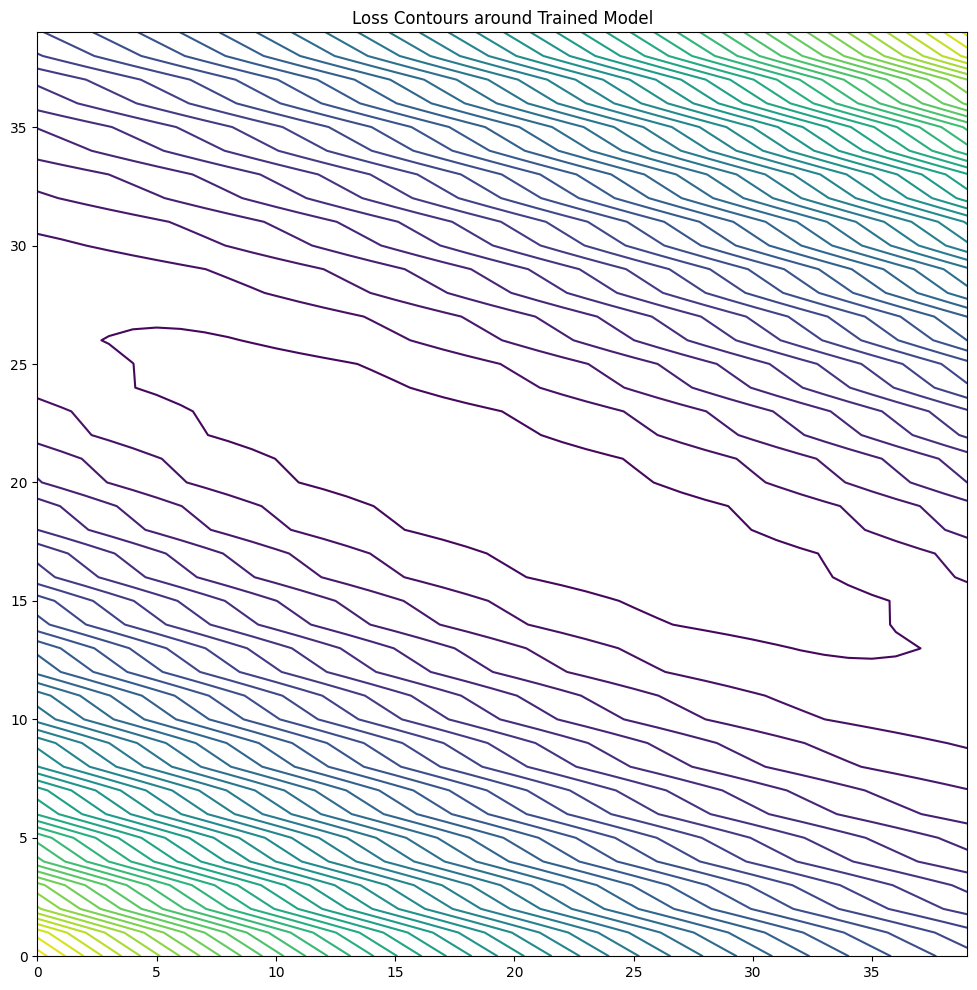

In [17]:
#1. Visualize Contour
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()


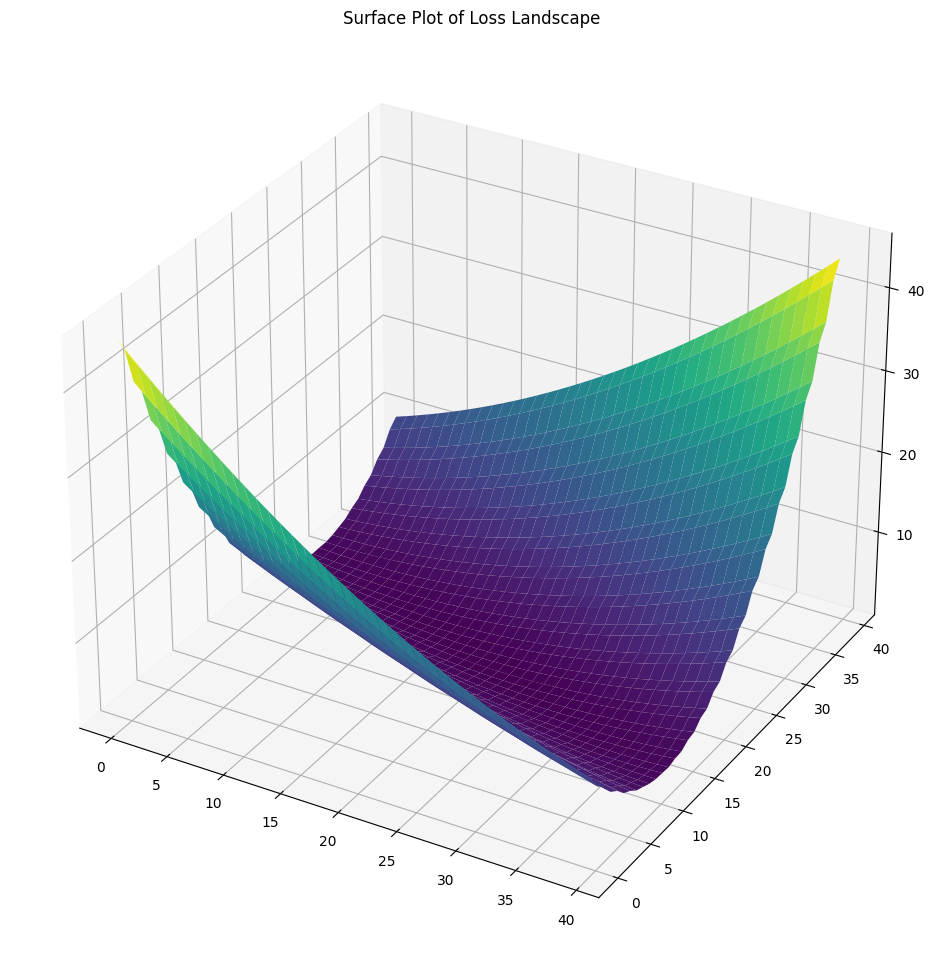

In [16]:
#2. Visualize Loss Surface
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()